In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.measurement

In [8]:
# Create a session
session = Session(engine)

In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print('Most Recent Date: ' , recent_date)


Most Recent Date:  ('2017-08-23',)


In [12]:
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)


Query Date:  2016-08-23


In [13]:
# Perform a query to retrieve the date and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
Meas_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
# Print the results (optional)
Meas_df.head()


,Date,Precipitation
0,2016-08-23,0.0
1,2016-08-24,2.0
2,2016-08-25,2.0
3,2016-08-26,0.0
4,2016-08-27,0.0


In [14]:
#Drop null values
Meas_df = Meas_df.dropna()
# Sort the dataframe by date
Meas_df = Meas_df.sort_values(by='Date')
# Reset the index
Meas_df = Meas_df.reset_index(drop=True)
# Set the index to 'Date'
#Meas_df.set_index('Date', inplace=True)

Meas_df


,Date,Precipitation
0,2016-08-23,0.0
1,2016-08-23,0.5
2,2016-08-23,1.3
3,2016-08-23,17.8
4,2016-08-23,3.8
...,...,...
2016,2017-08-22,12.7
2017,2017-08-23,0.0
2018,2017-08-23,2.0
2019,2017-08-23,0.0


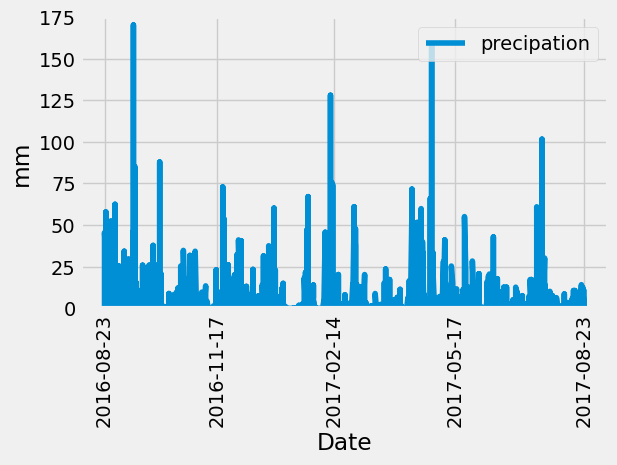

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(Meas_df['Date'], Meas_df['Precipitation'], label='precipation')

# Selecting only specific dates to show on the x-axis
selected_dates = [Meas_df['Date'].iloc[0], Meas_df['Date'].iloc[len(Meas_df) // 4], 
                  Meas_df['Date'].iloc[len(Meas_df) // 2], Meas_df['Date'].iloc[3 * len(Meas_df) // 4], 
                  Meas_df['Date'].iloc[-1]]

# Formatting x-axis and rotate x-axis labels for better readability
plt.xticks(selected_dates,rotation=90)
# Setting y-axis limits
plt.ylim(0, 175)
# Labeling axes and title
plt.xlabel('Date')
plt.ylabel('mm')
#plt.title('Precipitation Data for the Last 12 Months')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = Meas_df['Precipitation'].describe()
# Convert summary statistics to DataFrame with custom column names
summary_stats_df = pd.DataFrame({
    'Statistics': summary_stats.index,
    'Precipitation': summary_stats.values
})
#Set statistics as index
summary_stats_df.set_index('Statistics', inplace=True)
# Print the DataFrame
summary_stats_df

,Precipitation
Statistics,
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).group_by(Station.station).count()
total_stations


9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
list_active_stations = session.query(Station.station, func.count(Station.id).label('count')) \
                               .group_by(Station.station) \
                               .order_by(func.count(Station.id).desc()) \
                               .all()
# Print the result
print("Station activity count:")
for station, count in list_active_stations:
    print(f"Station: {station}, Count: {count}")

Station activity count:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = list_active_stations[0][0]  

# Query to calculate lowest, highest, and average temperature
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)) \
                           .filter(Measurement.station == most_active_station) \
                           .all()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"For the most active station ({most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")



For the most active station (USC00519281):
Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.03582251082252


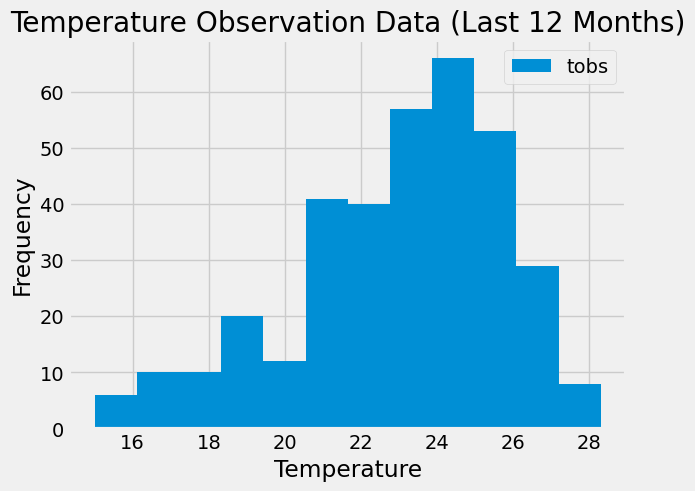

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs) \
                 .filter(Measurement.station == most_active_station) \
                 .filter(Measurement.date >= query_date) \
                 .all()

# Extract temperature values from the results
temperatures = [result[0] for result in results]

#put results in to a dataframe
temperature_df = pd.DataFrame(temperatures, columns=['Temperature'])

# Plot the results as a histogram
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.legend()
plt.grid(True)
plt.show()

# Close Session

In [21]:
# Close Session
session.close()
